In [11]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt
import random
import torch
random.seed(0) # Set seed for NumPy
np.random.seed(0) # Set seed for PyTorch (for both CPU and GPU)
torch.manual_seed(0)
if torch.cuda.is_available(): 
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_df = pd.read_csv('train_dataset/metadata.csv')
test_df = pd.read_csv('test_dataset/metadata.csv')
val_df = pd.read_csv('validation_dataset/metadata.csv')

In [12]:
print(train_df['diagnosis'].value_counts())

diagnosis
nevus                         1205
melanoma                      1113
pigmented benign keratosis    1099
basal cell carcinoma           514
squamous cell carcinoma        197
vascular lesion                142
actinic keratosis              130
dermatofibroma                 115
Name: count, dtype: int64


In [13]:
class_mapping = {
    "actinic keratosis": 0,
    "basal cell carcinoma": 1,
    "dermatofibroma": 2,
    "melanoma": 3,
    "nevus": 4,
    "pigmented benign keratosis": 5,
    "squamous cell carcinoma": 6,
    "vascular lesion":7
}
class_mapping

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'squamous cell carcinoma': 6,
 'vascular lesion': 7}

In [14]:
from PIL import Image
import os

import torchvision.transforms as transforms

# Define image transformations (resize, convert to tensor, and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images to 224x224 (matching ResNet input size)
    transforms.ToTensor()
])

class Dataset():
    def __init__(self, dataframe, transform, train='train'):
        self.dataframe=dataframe
        self.train = train
        self.transform = transform
        self.path_to_image=self._create_path_to_image_dict()
        self.paths=list(self.path_to_image.keys())
        self.labels=list(self.path_to_image.values())

    def _create_path_to_image_dict(self):
      path_to_image={}
      for index,row in self.dataframe.iterrows():
        if self.train == 'train':
          img_path = os.path.join('train_dataset/',row['isic_id']+'.jpg')
        elif self.train == 'test':
          img_path = os.path.join('test_dataset/',row['isic_id']+'.jpg')
        else:
            img_path = os.path.join('validation_dataset/',row['isic_id']+'.jpg')
        label=row['diagnosis']
        path_to_image[img_path]=label
      return path_to_image

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        img_path=self.paths[index]
        img_label=self.labels[index]
        image=Image.open(img_path)
        image=self.transform(image)
        if self.train == 'val':
            return image, class_mapping[img_label], index
        return image, img_label, index

In [15]:
train_df = Dataset(train_df, transform)
val_df = Dataset(val_df, transform,train='val')
test_df = Dataset(test_df, transform,train='test')

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.optim import Adam

# Load pre-trained ResNet50 model from torchvision
base_model = models.resnet50(pretrained=True)

num_classes = 8  # Adjust this based on your dataset
base_model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(base_model.fc.in_features, 128),  # Add a fully connected layer
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Final layer with number of classes
    nn.Softmax(dim=1)  # Softmax activation for multi-class classification
)

for param in base_model.parameters():
    param.requires_grad = False  # Freeze all layers except the fully connected ones

# Unfreeze the final fully connected layer
for param in base_model.fc.parameters():
    param.requires_grad = True
    
# class_weights = torch.tensor([0.5, 2.0, 1.0, 0.8, 0.2, 3.0, 0.7, 1.2]).to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = Adam(base_model.fc.parameters(), lr=0.0008)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)
x = 5

/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 4  # Adjust based on your memory and hardware
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False)

In [18]:
class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 num_epochs):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        if self.selection_criterion == 'random':
          self.train_indices = []
        self.num_epochs = num_epochs
        # self.best_acc = 0

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """
        accuracy_scores = []
        for iteration in range(self.iterations):
            print(f"--------- Number of Iteration {iteration} ---------")
            if self.selection_criterion == 'random':
                self._random_sampling()
            elif self.selection_criterion == 'competence_based_30':
                self._competence_based_sampling(iteration+1)
            else:
              self._custom_sampling(iteration)
            
            train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
            label_df = [class_mapping[train_df.__getitem__(index)[1]] for index in self.train_indices]
            self._train_model(train_images, label_df)
            self.model.load_state_dict(torch.load(f"best_{self.selection_criterion}_model.pth"))
            accuracy = self._evaluate_model()
            accuracy_scores.append(accuracy)
        return accuracy_scores
        
    def calculate_class_weights(self, label_counts, num_classes=8):
        total_samples = sum(label_counts.values())
        class_weights = torch.zeros(num_classes)
        
        for cls in range(num_classes):
            if cls in label_counts:
                class_weights[cls] = total_samples / (num_classes * label_counts[cls])
            else:
                class_weights[cls] = 1.0  # Handle the case where a class has zero samples in the current epoch
    
        return class_weights
    
    def _train_model(self, train_images, label_df):
      label_counts = defaultdict(int)
      for label in label_df:
                label_counts[label] += 1
      class_weights = self.calculate_class_weights(label_counts, 8).to(device)
      loss_f = nn.CrossEntropyLoss(weight=class_weights)
        
      train_images_tensor = torch.stack(train_images)
      label_df_tensor = torch.tensor(label_df)
      train_dataset = TensorDataset(train_images_tensor, label_df_tensor)

      batch_size = 32
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      best_acc = 0
      for epoch in range(self.num_epochs):
                self.model.train()
                running_loss = 0.0  # Track the running loss
                correct_predictions = 0
                total_predictions = 0
                # Training loop
                for inputs, labels in train_loader:
                    inputs = inputs
                    inputs= inputs.to(device)
                    labels = torch.tensor(labels).to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(inputs)
                    # outputs = outputs.logits
                    loss = loss_f(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
        
                    # Calculate accuracy
                    _, preds = torch.max(outputs, 1)
                    correct_predictions += torch.sum(preds == labels)
                    total_predictions += inputs.shape[0]

                # Print loss and accuracy at the end of each epoch
                epoch_loss = running_loss / len(train_loader)
                epoch_acc = correct_predictions.double() / total_predictions
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
          
                val_acc = self._check_model()
                if val_acc > best_acc: 
                    best_acc = val_acc
                    torch.save(self.model.state_dict(), f"best_{self.selection_criterion}_model.pth")
      print("--"*30)
        
    def _check_model(self):
        self.model.eval()
        running_corrects = 0
        total_predictions = 0.0
    
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        val_acc = running_corrects.double() / total_predictions
        return val_acc.item()
        
    def _evaluate_model(self):
        """
        Evaluate the model
        :return:
        accuracy: float, accuracy of the model
        """
        self.model.eval()
        running_corrects = 0
        test_images_tensor = torch.stack(test_images)
        label_df_tensor = torch.tensor(test_label_df)
        test_dataset = TensorDataset(test_images_tensor, label_df_tensor)
        batch_size = 32  # Adjust based on your memory and hardware
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        total_predictions = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        test_acc = running_corrects.double() / total_predictions
        return test_acc.item()

    def _random_sampling(self):
      selected_indices = np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
      selected_indices = selected_indices.tolist()
      self.train_indices = self.train_indices + selected_indices

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)
        
    def _competence_based_sampling(self, itr):
      model = self.model
      
      X_unlabeled = [train_df.__getitem__(index)[0] for index in self.available_pool_indices]
      
      pool_images_tensor = torch.stack(X_unlabeled)
      pool_dataset = TensorDataset(pool_images_tensor)
    
      batch_size = 32
      pool_loader = DataLoader(pool_dataset, batch_size=batch_size, shuffle=False)
      model.eval()
      outputs = []
      with torch.no_grad():
                for inputs in pool_loader:
                    inputs = inputs[0]
                    inputs = inputs.to(device)
                    x = model(inputs)
                    if x.shape[0] != batch_size:
                        padding_tensor = torch.full((batch_size - x.shape[0], 8), 0).to(device)
                        c = batch_size - x.shape[0]
                        x = torch.cat([x, padding_tensor])
                    else:
                        outputs.append(x)
      probabilities = torch.cat(outputs, dim=0)
      probabilities = probabilities[:-c]
      probabilities_cpu = probabilities.cpu().numpy()
      p_scores = []
      for prob in probabilities_cpu:
         max_prob = np.max(prob)  
         p_score = (1 - max_prob) / max_prob
         p_scores.append(p_score)
          
      p_scores = np.array(p_scores)
      cdf = np.cumsum(p_scores) / np.sum(p_scores)
    
      C0 = 0.5
      c_t = min(1, np.sqrt((itr / self.iterations) * (1 - C0**2) / self.iterations + C0**2))

      selected_indices = np.where(p_scores > c_t)[0]
      # print(selected_indices.shape)
        
      if len(selected_indices) > 0:
        if selected_indices.shape[0] < self.budget_per_iter:
            sampled_indices = selected_indices.tolist()
            sorted_p_scores_indices = np.argsort(p_scores)
            remaining_indices = np.setdiff1d(sorted_p_scores_indices, selected_indices)
            additional_samples = remaining_indices[:self.budget_per_iter - len(selected_indices)]
            sampled_indices.extend(additional_samples)
        else:
            selected_cdf_values = cdf[selected_indices]
            selected_cdf_norm = selected_cdf_values / np.sum(selected_cdf_values)
            sampled_indices = np.random.choice(selected_indices, self.budget_per_iter, p=selected_cdf_norm, replace=False)
      else:
        sampled_indices = np.random.choice(len(p_scores), self.budget_per_iter, replace=False)
    
      temp = np.array(self.available_pool_indices)
      selected_indices = temp[sampled_indices]

      self.train_indices = self.train_indices + selected_indices.tolist()

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)



In [19]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [20]:
available_pool_indices = []
for i in range(len(train_df)):
    image, label, index = train_df[i]
    available_pool_indices.append(index)

test_indices = []
for i in range(len(test_df)):
    image, label, index = test_df[i]
    test_indices.append(index)
test_images = [test_df.__getitem__(index)[0] for index in test_indices]
test_label_df = [class_mapping[test_df.__getitem__(index)[1]] for index in test_indices]

In [21]:
train_indices = [1372,
 1277,
 1255,
 1423,
 2925,
 1963,
 2335,
 1923,
 3791,
 1239,
 909,
 134,
 1547,
 3931,
 2467,
 2832,
 1789,
 3022,
 2424,
 780,
 2412,
 3038,
 2158,
 3335,
 1868,
 1771,
 2015,
 1535,
 710,
 3007]
available_pool_set = set(available_pool_indices)
train_set = set(train_indices)
available_pool_indices = list(available_pool_set - train_set)

In [22]:
iterations = 20
budget_per_iter = 60 # 30
num_epoch = 30
selection_criteria = ['competence_based'] # competence_based_30
accuracy_scores_dict = defaultdict(list)
model = base_model

--------- Number of Iteration 0 ---------


/tmp/ipykernel_18151/3290251014.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/30], Loss: 2.0908, Accuracy: 0.1333


/tmp/ipykernel_18151/3290251014.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/30], Loss: 2.0405, Accuracy: 0.3000
Epoch [3/30], Loss: 2.0157, Accuracy: 0.4333
Epoch [4/30], Loss: 1.9847, Accuracy: 0.5500
Epoch [5/30], Loss: 1.9421, Accuracy: 0.6333
Epoch [6/30], Loss: 1.8569, Accuracy: 0.6500
Epoch [7/30], Loss: 1.8356, Accuracy: 0.7167
Epoch [8/30], Loss: 1.7637, Accuracy: 0.7667
Epoch [9/30], Loss: 1.7187, Accuracy: 0.8333
Epoch [10/30], Loss: 1.6685, Accuracy: 0.8833
Epoch [11/30], Loss: 1.6192, Accuracy: 0.8500
Epoch [12/30], Loss: 1.5859, Accuracy: 0.9000
Epoch [13/30], Loss: 1.5456, Accuracy: 0.9333
Epoch [14/30], Loss: 1.5485, Accuracy: 0.8667
Epoch [15/30], Loss: 1.4946, Accuracy: 0.9167
Epoch [16/30], Loss: 1.4720, Accuracy: 0.9000
Epoch [17/30], Loss: 1.4577, Accuracy: 0.9167
Epoch [18/30], Loss: 1.4171, Accuracy: 0.9333
Epoch [19/30], Loss: 1.4086, Accuracy: 0.9500
Epoch [20/30], Loss: 1.3974, Accuracy: 0.9500
Epoch [21/30], Loss: 1.3967, Accuracy: 0.9500
Epoch [22/30], Loss: 1.3976, Accuracy: 0.9333
Epoch [23/30], Loss: 1.3836, Accuracy: 0.9

/tmp/ipykernel_18151/3290251014.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 1 ---------
Epoch [1/30], Loss: 1.6282, Accuracy: 0.7000
Epoch [2/30], Loss: 1.6126, Accuracy: 0.8111
Epoch [3/30], Loss: 1.5797, Accuracy: 0.7889
Epoch [4/30], Loss: 1.6058, Accuracy: 0.8111
Epoch [5/30], Loss: 1.5843, Accuracy: 0.8111
Epoch [6/30], Loss: 1.5660, Accuracy: 0.8222
Epoch [7/30], Loss: 1.5224, Accuracy: 0.8889
Epoch [8/30], Loss: 1.5479, Accuracy: 0.8444
Epoch [9/30], Loss: 1.4863, Accuracy: 0.8889
Epoch [10/30], Loss: 1.5156, Accuracy: 0.9000
Epoch [11/30], Loss: 1.5263, Accuracy: 0.8889
Epoch [12/30], Loss: 1.5020, Accuracy: 0.9000
Epoch [13/30], Loss: 1.4951, Accuracy: 0.9111
Epoch [14/30], Loss: 1.5070, Accuracy: 0.9111
Epoch [15/30], Loss: 1.4878, Accuracy: 0.9000
Epoch [16/30], Loss: 1.4815, Accuracy: 0.9111
Epoch [17/30], Loss: 1.4514, Accuracy: 0.9111
Epoch [18/30], Loss: 1.4469, Accuracy: 0.9111
Epoch [19/30], Loss: 1.4437, Accuracy: 0.9111
Epoch [20/30], Loss: 1.4765, Accuracy: 0.9000
Epoch [21/30], Loss: 1.4551, Accuracy: 0.9222
E

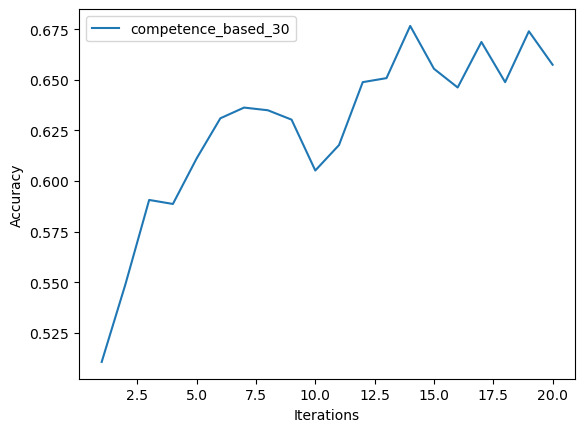

In [23]:
for criterion in selection_criteria:
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      num_epochs=num_epoch)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
generate_plot(accuracy_scores_dict)

In [24]:
accuracy_scores_dict

defaultdict(list,
            {'competence_based_30': [0.5105820105820106,
              0.548941798941799,
              0.5906084656084656,
              0.5886243386243386,
              0.611111111111111,
              0.6309523809523809,
              0.6362433862433862,
              0.6349206349206349,
              0.6302910052910052,
              0.6051587301587301,
              0.6177248677248677,
              0.6488095238095237,
              0.6507936507936507,
              0.6765873015873015,
              0.6554232804232804,
              0.6461640211640212,
              0.6686507936507936,
              0.6488095238095237,
              0.673941798941799,
              0.6574074074074073]})